[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_09_redes_neuronales-published.ipynb)

# Redes neuronales


Vamos nuevamente a trabajar con los datos de `iris` para entrenar (y antes construir) una Red Neuronal.

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    dataset = load_iris()
    X = dataset["data"]
    y = dataset["target"]
    y = LabelEncoder().fit_transform(y)
    return np.array(X), np.array(y)
X, y = get_data()
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

La propuesta es empezar por el esqueleto de las 2 clases que usaremos para esta tarea e ir implementado los métodos a medida que avancemos.

Al final de este notebook se encuentran ambas clases completas. Pueden copiar el código desde allí mismo o implementarlo. La idea es que en cada avance podamos comprender la parte del proceso que estamos realizando, por lo cual se recomienda seguir la guia propuesta e ir completando sólo lo que es necesario para cada punto.

In [2]:
class Capa:
    def __init__(self, neuronas):
        self.neuronas = neuronas

    def forward(self, inputs, weights, bias, activation):
        """
        Forward Propagation de la capa
        """
        Z = np.dot(inputs, weights) + bias
        if activation == 'relu':
            A = self.relu(Z)
        elif activation == 'softmax':
            A = self.softmax(Z)
        else:
            raise ValueError(f"Función de activación no soportada: {activation}")
        return A, Z

    def relu(self, inputs):
        """
        ReLU: función de activación
        """
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        """
        Softmax: función de activación (para clasificación multiclase)
        """
        exps = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))  # para estabilidad numérica
        return exps / np.sum(exps, axis=1, keepdims=True)

    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Backward Propagation de la capa
        """
        m = A_prev.shape[0]

        if activation == 'relu':
            dZ = self.relu_derivative(dA_curr, Z_curr)
        elif activation == 'softmax':
            # Nota: esto asume uso de softmax + cross-entropy -> dZ = y_pred - y_true
            dZ = dA_curr
        else:
            raise ValueError(f"Función de activación no soportada: {activation}")

        dW = np.dot(A_prev.T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = np.dot(dZ, W_curr.T)

        return dA_prev, dW, db

    def relu_derivative(self, dA, Z):
        """
        ReLU: gradiente de ReLU
        """
        dZ = dA.copy()
        dZ[Z <= 0] = 0
        return dZ

In [3]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = []  # Capas
        self.arquitectura = []  # Lista de tuplas (input_dim, output_dim, activation)
        self.pesos = []  # Lista de (W, b)
        self.memoria = []  # Lista de (Z, A)
        self.gradientes = []  # Lista de (dW, db)
        self.lr = learning_rate

    def add(self, capa):
        """
        Agregar capa a la red
        """
        self.red.append(capa)

    def _compile(self, input_dim):
        """
        Inicializar la arquitectura y pesos
        """
        self._init_weights(input_dim)

    def _init_weights(self, input_dim):
        """
        Inicializa pesos y arquitectura
        """
        np.random.seed(42)
        prev_dim = input_dim

        for capa in self.red:
            output_dim = capa.neuronas
            W = np.random.randn(prev_dim, output_dim) * np.sqrt(2. / prev_dim)  # He init
            b = np.zeros((1, output_dim))
            self.pesos.append((W, b))
            self.arquitectura.append((prev_dim, output_dim))
            prev_dim = output_dim

    def _forwardprop(self, data):
        """
        Pasada forward completa por la red
        """
        A = data
        self.memoria = []

        for i, capa in enumerate(self.red):
            W, b = self.pesos[i]
            activation = 'relu' if i < len(self.red) - 1 else 'softmax'
            A, Z = capa.forward(A, W, b, activation)
            self.memoria.append((Z, A))

        return A

    def _backprop(self, predicted, actual):
        """
        Backward completo
        """
        m = actual.shape[0]
        self.gradientes = []

        # Cálculo del gradiente inicial: softmax + cross-entropy simplifica a (y_pred - y_true)
        dA = predicted - actual

        for i in reversed(range(len(self.red))):
            capa = self.red[i]
            W, b = self.pesos[i]
            Z, A = self.memoria[i]
            A_prev = self.memoria[i - 1][1] if i > 0 else self.last_input
            activation = 'relu' if i < len(self.red) - 1 else 'softmax'

            dA, dW, db = capa.backward(dA, W, Z, A_prev, activation)
            self.gradientes.insert(0, (dW, db))  # prepend

    def _update(self):
        """
        Actualizar pesos y bias
        """
        for i in range(len(self.pesos)):
            W, b = self.pesos[i]
            dW, db = self.gradientes[i]
            self.pesos[i] = (W - self.lr * dW, b - self.lr * db)

    def _get_accuracy(self, predicted, actual):
        """
        Calcular accuracy
        """
        pred_labels = np.argmax(predicted, axis=1)
        true_labels = np.argmax(actual, axis=1)
        return np.mean(pred_labels == true_labels)

    def _calculate_loss(self, predicted, actual):
        """
        Cross-entropy loss
        """
        m = actual.shape[0]
        eps = 1e-15
        predicted = np.clip(predicted, eps, 1 - eps)
        loss = -np.sum(actual * np.log(predicted)) / m
        return loss

    def train(self, X_train, y_train, epochs=100):
        """
        Entrenamiento
        """
        self._compile(X_train.shape[1])
        self.last_input = X_train

        # One-hot encode y_train
        y_onehot = np.zeros((y_train.size, y_train.max() + 1))
        y_onehot[np.arange(y_train.size), y_train] = 1

        for epoch in range(epochs):
            # Forward
            predictions = self._forwardprop(X_train)

            # Loss y Accuracy
            loss = self._calculate_loss(predictions, y_onehot)
            acc = self._get_accuracy(predictions, y_onehot)

            # Backward
            self._backprop(predictions, y_onehot)

            # Update pesos
            self._update()

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")


Los items que se presentan a continuación tienen como objetivo explorar las clases que componen la red neuronal propuesta, comprender su arquitectura y funcionamiento.

Nuevamente, lo ideal es no mirar todos los métodos hasta que llegue el momento de utilizarlos.

1. Crear una Red Neuronal con 6 nodos en la primera capa, 8 en la segunda, 10 en la tercer y finalmente 3 en la última, utilizando los métodos `add()`, `_compile()` de la clase `RedNeuronal` y el constructor de la clase `Capa`.
  
    Imprimir la arquitectura del modelo y asegurarse de obtener:

    ```
    [{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'},
    {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'},
    {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'},
    {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]
    ```

    Dibujar la red en papel.

1. Inicializar los pesos de la red del punto anterior (`_init_weights(datos)`) y verificar que los pesos tienen dimensión correcta:

    ```
    capa 0: w=(4, 6) - b=(1, 6)
    capa 1: w=(6, 8) - b=(1, 8)
    capa 2: w=(8, 10) - b=(1, 10)
    capa 3: w=(10, 3) - b=(1, 3)
    ```

    Definir las matrices que se corresponden con las capas de manera que una pasada pueda ser interpretada como el producto de todas ellas. Recordar que en cada paso por cada capa estaremos computando por cada neurona de la capa siguiente:

    $$Z = \sum_{i=1}^{n} X_i \times W_i + b$$

1. Funciones de activación de una `Capa`:

    1. Verificar que el funcionamiento de `ReLU` se corresponda con:

        ```
        if input > 0:
            return input
        else:
            return 0
        ```

    1. Verificar que el funcionamiento de `softmax` se corresponda con:

        $$\sigma(Z)_i = \frac{e^{z_i}}{\sum_{i=1}^{n} e^{z_j}}$$

    **Nota**: para probar estos dos métodos puede ser util construir un vector de la siguiente manera: `np.array([[1.3, 5.1, -2.2, 0.7, 1.1]])` que genera un vector de tamaño (1,5).

1. Avancemos con `_forwardprop(datos)`, si corremos la red inicializada con los datos:

    1. ¿Qué nos tipo de objeto nos devuelve este método?

    1. ¿Qué quiere decir cada uno de los valores?

    1. La primera fila, que se correspondería con la primera observación del dataset, ¿qué resultados nos da?¿qué es más probable: 'setosa', 'versicolor' o 'virginica'?¿qué valor es el real?¿por qué?

1. Arrancamos a propagar para atrás lo aprendido en la primera pasada. Esto lo realizaremos con el método `_backprop`.

    1. ¿Cómo es la derivada de la función de activación `ReLU`?¿Su código es correcto?

    1. ¿Cuál es la operación matemática que hace la función `backward` de la clase `Capa` en el caso de tener como activación a `relu`?

    1. El método `_backprop` toma 2 parámetros: `predicted` y `actual`. ¿qué debemos pasarle en dicho lugar?

        Si la respuesta no fue: en `predicted` le pasamos el resultado de `_forwardprop(...)` y en `actual` le pasamos `y`.... volver a pensarlo. ;-)

    1. Verificar que los `gradientes` y los `pesos` para cada una de las capas tienen el mismo tamaño.

1. Preparemos por último las funciones necesarias para el entrenamiento. Describir brevemente qué hacen las funciones:

    - `_get_accuracy`
    - `_calculate_loss`
    - `_update`

1. Incluyamos finalmente la función `train` y entrenemos una red con la arquitectura propuesta en el punto 1 por 200 epocas.

    1. ¿Qué valores se imprimen?¿Qué es posible interpretar de ellos?

    1. Graficar el _accuracy_ y la _loss_ que arroja el entramiento en función de las _epochs_. ¿Qué se puede concluir? Probablemente la señal sea ruidosa, por lo que se recomienda hacer un suavizado por ventanas deslizantes.

1. Reimplementar la clase `RedNeuronal` utilizando PyTorch

    Hasta ahora hemos construido nuestra propia red neuronal "desde cero", lo cual nos permitió comprender en profundidad cómo funciona cada componente: inicialización de pesos, funciones de activación, forward y backward propagation, cálculo de loss y accuracy, y actualización de pesos.

    Sin embargo, en proyectos reales y más complejos, utilizamos frameworks como **PyTorch** que abstraen estas tareas, permitiéndonos enfocarnos más en el diseño de la arquitectura y el análisis de los resultados.  

    **Objetivo de este inciso**: recrear la arquitectura y entrenamiento de nuestra red neuronal, pero usando herramientas provistas por PyTorch. Esto implica:

    1. Implementar una clase `RedNeuronalTorch` que herede de `nn.Module` y contenga una red con la misma arquitectura:  
    - Entrada de dimensión 4 (por las características del dataset Iris)
    - Capas ocultas de 6, 8 y 10 nodos respectivamente
    - Capa de salida con 3 nodos y activación `softmax`

    2. Entrenar esta nueva red por 200 épocas utilizando:
    - Función de pérdida: `nn.CrossEntropyLoss`
    - Optimizador: `torch.optim.SGD`
    - Tasa de aprendizaje: 0.01

    3. Comparar los resultados obtenidos con los del entrenamiento anterior (implementación manual). Algunas preguntas a responder:
    - ¿La convergencia es más rápida o más lenta?
    - ¿Cómo se comporta la pérdida durante el entrenamiento?
    - ¿Cuál implementación fue más fácil de modificar o extender?

    4. Graficar la evolución de la **pérdida** y el **accuracy** durante las épocas para ambas implementaciones (manual y PyTorch), idealmente en la misma figura para facilitar la comparación. Podés aplicar una media móvil para suavizar la señal.

    > 💡 **Sugerencia pedagógica**: antes de realizar este inciso, se recomienda repasar los notebooks `9a` y `9b`, donde se presentan una introducción a los tensores y al workflow de ML usando PyTorch.


Crédito: este ejercicio se base en la propuesta de Joe Sasson publicada en [Towards Data Science](https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605).

### Código completo (Implementación con Numpy)


In [62]:
class Capa:
    def __init__(self, neuronas):
        self.neuronas = neuronas

    def forward(self, inputs, weights, bias, activation):
        """
        Forward Propagation de la capa
        """
        Z_curr = np.dot(inputs, weights.T) + bias

        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)

        return A_curr, Z_curr

    def relu(self, inputs):
        """
        ReLU: función de activación
        """

        return np.maximum(0, inputs)

    def softmax(self, inputs):
        """
        Softmax: función de activación
        """
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        """
        Backward Propagation de la capa
        """
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr)
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)

        return dA, dW, db

    def relu_derivative(self, dA, Z):
        """
        ReLU: gradiente de ReLU
        """
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ


In [63]:
class RedNeuronal:
    def __init__(self, learning_rate=0.01):
        self.red = [] ## capas
        self.arquitectura = [] ## mapeo de entradas -> salidas
        self.pesos = [] ## W, b
        self.memoria = [] ## Z, A
        self.gradientes = [] ## dW, db
        self.lr = learning_rate

    def add(self, capa):
        """
        Agregar capa a la red
        """
        self.red.append(capa)

    def _compile(self, data):
        """
        Inicializar la arquitectura
        """
        for idx, _ in enumerate(self.red):
            if idx == 0:
                self.arquitectura.append({'input_dim': data.shape[1],
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            elif idx > 0 and idx < len(self.red)-1:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas,
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'relu'})
            else:
                self.arquitectura.append({'input_dim': self.red[idx-1].neuronas,
                                        'output_dim': self.red[idx].neuronas,
                                        'activation':'softmax'})
        return self

    def _init_weights(self, data):
        """
        Inicializar arquitectura y los pesos
        """
        self._compile(data)

        np.random.seed(99)

        for i in range(len(self.arquitectura)):
            self.pesos.append({
                'W':np.random.uniform(low=-1, high=1,
                        size=(self.arquitectura[i]['input_dim'],
                            self.arquitectura[i]['output_dim']
                            )),
                'b':np.zeros((1, self.arquitectura[i]['output_dim']))})

        return self

    def _forwardprop(self, data):
        """
        Pasada forward completa por la red
        """
        A_curr = data

        for i in range(len(self.pesos)):
            A_prev = A_curr
            A_curr, Z_curr = self.red[i].forward(inputs=A_prev,
                                                    weights=self.pesos[i]['W'].T,
                                                    bias=self.pesos[i]['b'],
                                                    activation=self.arquitectura[i]['activation'])

            self.memoria.append({'inputs':A_prev, 'Z':Z_curr})

        return A_curr

    def _backprop(self, predicted, actual):
        """
        Pasada backward completa por la red
        """
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples

        dA_prev = dscores

        for idx, layer in reversed(list(enumerate(self.red))):
            dA_curr = dA_prev

            A_prev = self.memoria[idx]['inputs']
            Z_curr = self.memoria[idx]['Z']
            W_curr = self.pesos[idx]['W']

            activation = self.arquitectura[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr.T, Z_curr, A_prev, activation)

            self.gradientes.append({'dW':dW_curr, 'db':db_curr})

        self.gradientes = list(reversed(self.gradientes))  # Reverse the gradients list

    def _update(self):
        """
        Actualizar el modelo --> lr * gradiente
        """
        lr = self.lr
        for idx, layer in enumerate(self.red):
            self.pesos[idx]['W'] -= lr * self.gradientes[idx]['dW']
            self.pesos[idx]['b'] -= lr * self.gradientes[idx]['db']

    def _get_accuracy(self, predicted, actual):
        """
        Calcular accuracy después de cada iteración
        """
        return np.mean(np.argmax(predicted, axis=1)==actual)

    def _calculate_loss(self, predicted, actual):
        """
        Calculate cross-entropy loss after each iteration
        """
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss

    def train(self, X_train, y_train, epochs):
        """
        Entrenar el modelo Stochastic Gradient Descent
        """
        self.loss = []
        self.accuracy = []

        self._init_weights(X_train)

        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))

            self._backprop(predicted=yhat, actual=y_train)

            self._update()

            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

        return (self.accuracy, self.loss)


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler

# Datos
X, y = get_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Clase
class RedNeuronalTorch:
    def __init__(self, arquitectura, lr=0.01):
        """
        arquitectura: lista con el número de neuronas por capa, e.g. [4, 6, 8, 10, 3]
        """
        self.capas = []
        self.lr = lr
        self.losses = []
        self.accuracies = []

        torch.manual_seed(42)  # reproducibilidad

        for i in range(len(arquitectura)-1):
            W = torch.randn(arquitectura[i], arquitectura[i+1], requires_grad=True) * 0.01
            b = torch.zeros(arquitectura[i+1], requires_grad=True)
            self.capas.append((W, b))

    def forward(self, X):
        a = X
        self.activaciones = [a]  # almacenar activaciones para backprop
        for i, (W, b) in enumerate(self.capas):
            z = a @ W + b
            a = F.relu(z) if i < len(self.capas)-1 else F.softmax(z, dim=1)
            self.activaciones.append(a)
        return a

    def compute_loss(self, logits, y):
        return F.cross_entropy(logits, y)

    def backward(self):
        for W, b in self.capas:
            W.grad.zero_()
            b.grad.zero_()

    def update(self):
        for W, b in self.capas:
            W.data -= self.lr * W.grad
            b.data -= self.lr * b.grad

    def fit(self, X, y, epochs=200):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            acc = (y_pred.argmax(dim=1) == y).float().mean().item()

            self.losses.append(loss.item())
            self.accuracies.append(acc)

            loss.backward()
            self.update()
            self.backward()  # limpiar gradientes

            if epoch % 20 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")


In [78]:
# Entrenamiento
X, y = get_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

model = RedNeuronalTorch([4, 6, 8, 10, 3], lr=0.01)
model.fit(X, y, epochs=200)


TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'

In [64]:
modelo = RedNeuronal()

modelo.add(Capa(6))
modelo.add(Capa(8))
modelo.add(Capa(10))
modelo.add(Capa(3))

modelo._compile(X)
print(modelo.arquitectura)

[{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'}, {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'}, {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'}, {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]


In [24]:
acc, loss = rn.train(X, y, epochs=200)


EPOCH: 0, ACCURACY: 0.52, LOSS: 1.2291019649679071
EPOCH: 20, ACCURACY: 0.6733333333333333, LOSS: 0.9177603793590958
EPOCH: 40, ACCURACY: 0.7533333333333333, LOSS: 0.8049407165316413
EPOCH: 60, ACCURACY: 0.7533333333333333, LOSS: 0.7470672461266537
EPOCH: 80, ACCURACY: 0.76, LOSS: 0.7028308076526014
EPOCH: 100, ACCURACY: 0.7733333333333333, LOSS: 0.665019939133662
EPOCH: 120, ACCURACY: 0.78, LOSS: 0.6313294643015023
EPOCH: 140, ACCURACY: 0.7866666666666666, LOSS: 0.60181533641816
EPOCH: 160, ACCURACY: 0.7933333333333333, LOSS: 0.5763777582273257
EPOCH: 180, ACCURACY: 0.8, LOSS: 0.5535363957084767


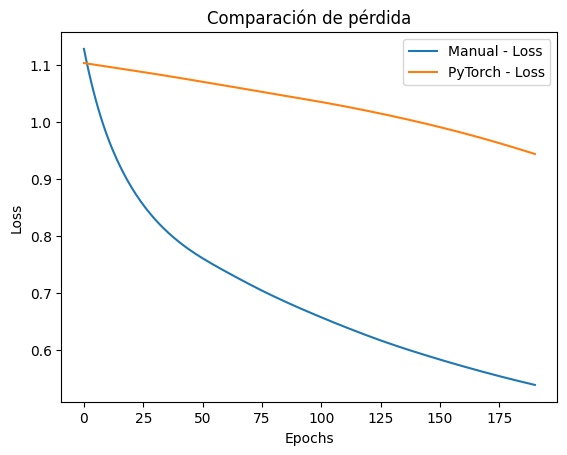

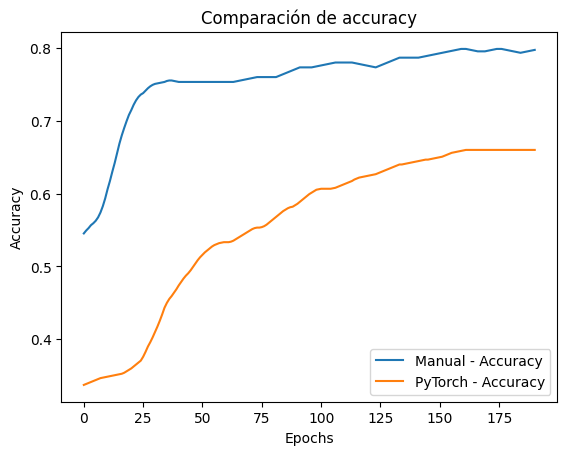

In [25]:
plt.plot(smooth(loss), label="Manual - Loss")
plt.plot(smooth(losses_torch), label="PyTorch - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparación de pérdida")
plt.show()

plt.plot(smooth(acc), label="Manual - Accuracy")
plt.plot(smooth(accuracies_torch), label="PyTorch - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Comparación de accuracy")
plt.show()

In [69]:
# Crear instancia de la red
red = RedNeuronal()

# Agregar capas
red.add(Capa(6))
red.add(Capa(8))
red.add(Capa(10))
red.add(Capa(3))

# Inicializar arquitectura con los datos X
red._compile(X)

# Mostrar arquitectura
print(red.arquitectura)

[{'input_dim': 4, 'output_dim': 6, 'activation': 'relu'}, {'input_dim': 6, 'output_dim': 8, 'activation': 'relu'}, {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'}, {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}]


In [70]:
red._init_weights(X)

for i, pesos in enumerate(red.pesos):
    print(f"Capa {i}: W={pesos['W'].shape} - b={pesos['b'].shape}")

Capa 0: W=(4, 6) - b=(1, 6)
Capa 1: W=(6, 8) - b=(1, 8)
Capa 2: W=(8, 10) - b=(1, 10)
Capa 3: W=(10, 3) - b=(1, 3)
Capa 4: W=(4, 6) - b=(1, 6)
Capa 5: W=(6, 8) - b=(1, 8)
Capa 6: W=(8, 10) - b=(1, 10)
Capa 7: W=(10, 3) - b=(1, 3)


In [71]:
relu_test = red.red[0].relu(np.array([[1.3, 5.1, -2.2, 0.7, 1.1]]))
print(relu_test)
# Salida esperada: [1.3, 5.1, 0, 0.7, 1.1]

[[1.3 5.1 0.  0.7 1.1]]


In [72]:
softmax_test = red.red[-1].softmax(np.array([[1.3, 5.1, -2.2, 0.7, 1.1]]))
print(softmax_test)
# Debe sumar 1 por fila y asignar probabilidad proporcional a exp de valores
print(softmax_test.sum(axis=1))  # debe ser 1.0

[[2.12319074e-02 9.49091411e-01 6.41148049e-04 1.16523179e-02
  1.73832156e-02]]
[1.]


In [73]:
output = red._forwardprop(X)
print(type(output))   # numpy.ndarray
print(output.shape)   # (150, 3), 150 instancias, 3 clases (probabilidades)

print(output[0])     # salida para la primera muestra
print("Predicción:", np.argmax(output[0]))
print("Etiqueta real:", y[0])

IndexError: list index out of range

EPOCH: 0, ACCURACY: 0.52, LOSS: 1.2291019649679071
EPOCH: 20, ACCURACY: 0.6733333333333333, LOSS: 0.9177603793590958
EPOCH: 40, ACCURACY: 0.7533333333333333, LOSS: 0.8049407165316413
EPOCH: 60, ACCURACY: 0.7533333333333333, LOSS: 0.7470672461266537
EPOCH: 80, ACCURACY: 0.76, LOSS: 0.7028308076526014
EPOCH: 100, ACCURACY: 0.7733333333333333, LOSS: 0.665019939133662
EPOCH: 120, ACCURACY: 0.78, LOSS: 0.6313294643015023
EPOCH: 140, ACCURACY: 0.7866666666666666, LOSS: 0.60181533641816
EPOCH: 160, ACCURACY: 0.7933333333333333, LOSS: 0.5763777582273257
EPOCH: 180, ACCURACY: 0.8, LOSS: 0.5535363957084767
EPOCH: 200, ACCURACY: 0.8, LOSS: 0.5333800726249432
EPOCH: 220, ACCURACY: 0.8133333333333334, LOSS: 0.5156232486021347
EPOCH: 240, ACCURACY: 0.8133333333333334, LOSS: 0.4998275647236989
EPOCH: 260, ACCURACY: 0.8133333333333334, LOSS: 0.4860293887176795
EPOCH: 280, ACCURACY: 0.8133333333333334, LOSS: 0.4736082966334892
EPOCH: 300, ACCURACY: 0.8133333333333334, LOSS: 0.4626392258633974
EPOCH: 32

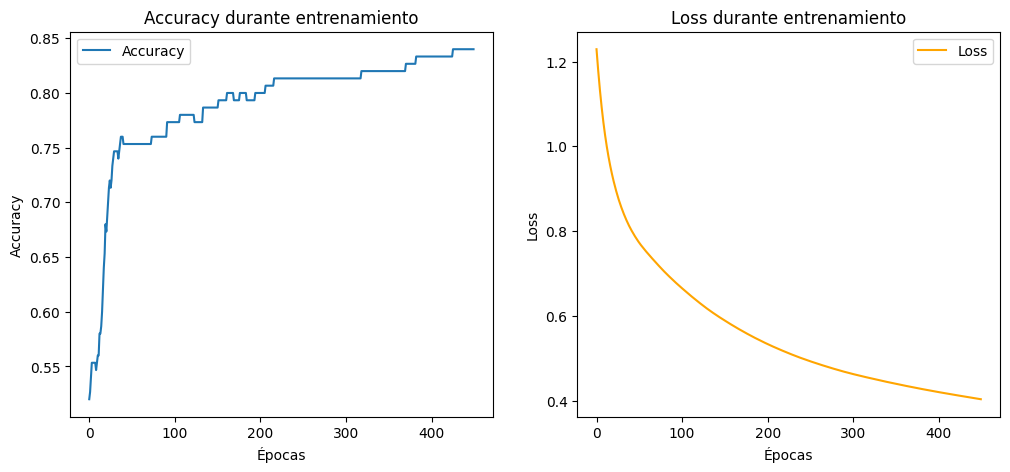

In [115]:
# Crear la red
red = RedNeuronal(learning_rate=0.01)

# Agregar las capas según el esquema: 6, 8, 10, 3 neuronas
red.add(Capa(6))
red.add(Capa(8))
red.add(Capa(10))
red.add(Capa(3))



# Entrenar la red por 200 épocas
accuracy, loss = red.train(X, y, epochs=450)

# Imprimir los últimos valores de accuracy y loss
print(f"Accuracy final: {accuracy[-1]}")
print(f"Loss final: {loss[-1]}")

# Graficar accuracy y loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(accuracy, label="Accuracy")
plt.title("Accuracy durante entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label="Loss", color='orange')
plt.title("Loss durante entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
import numpy as np

class RedNeuronalTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4, 6)
        self.layer2 = nn.Linear(6, 8)
        self.layer3 = nn.Linear(8, 10)
        self.layer4 = nn.Linear(10, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.softmax(self.layer4(x))
        return x

# Preparar datos para PyTorch
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.long)

model = RedNeuronalTorch()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 450
losses = []
accuracies = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_torch)
    loss = criterion(outputs, y_torch)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_torch).float().mean().item()
    accuracies.append(accuracy)

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch 0, Loss: 1.0919, Accuracy: 0.3333
Epoch 20, Loss: 1.0911, Accuracy: 0.3333
Epoch 40, Loss: 1.0901, Accuracy: 0.3333
Epoch 60, Loss: 1.0891, Accuracy: 0.3333
Epoch 80, Loss: 1.0880, Accuracy: 0.3333
Epoch 100, Loss: 1.0868, Accuracy: 0.3333
Epoch 120, Loss: 1.0856, Accuracy: 0.3333
Epoch 140, Loss: 1.0843, Accuracy: 0.3333
Epoch 160, Loss: 1.0829, Accuracy: 0.3333
Epoch 180, Loss: 1.0814, Accuracy: 0.3333
Epoch 200, Loss: 1.0799, Accuracy: 0.3333
Epoch 220, Loss: 1.0782, Accuracy: 0.3333
Epoch 240, Loss: 1.0765, Accuracy: 0.3333
Epoch 260, Loss: 1.0746, Accuracy: 0.3333
Epoch 280, Loss: 1.0726, Accuracy: 0.3333
Epoch 300, Loss: 1.0705, Accuracy: 0.3333
Epoch 320, Loss: 1.0681, Accuracy: 0.3333
Epoch 340, Loss: 1.0656, Accuracy: 0.3333
Epoch 360, Loss: 1.0629, Accuracy: 0.3467
Epoch 380, Loss: 1.0600, Accuracy: 0.3533
Epoch 400, Loss: 1.0569, Accuracy: 0.3600
Epoch 420, Loss: 1.0535, Accuracy: 0.3733
Epoch 440, Loss: 1.0499, Accuracy: 0.4200


In [104]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

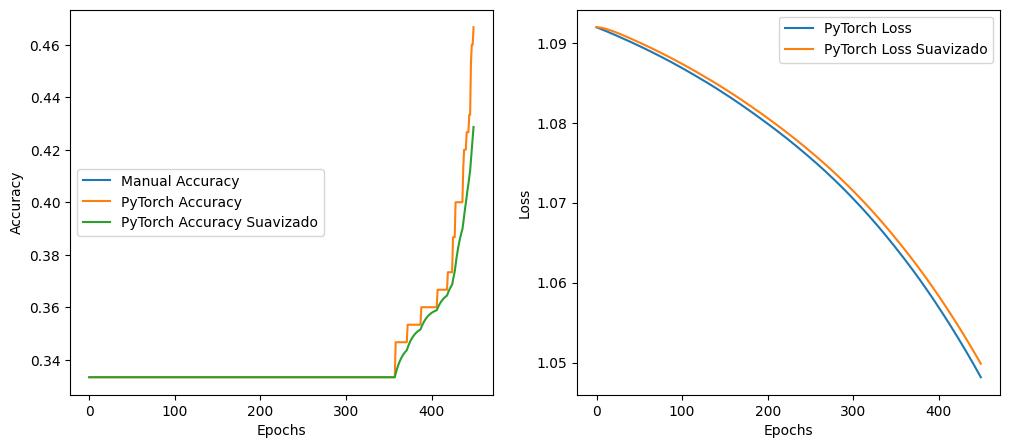

In [117]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(accuracy, label='Manual Accuracy')
#plt.plot(smooth_curve(accuracy), label='Manual Accuracy Suavizado')
plt.plot(accuracies, label='PyTorch Accuracy')
plt.plot(smooth_curve(accuracies), label='PyTorch Accuracy Suavizado')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
#plt.plot(loss, label='Manual Loss')
#plt.plot(smooth_curve(loss), label='Manual Loss Suavizado')
plt.plot(losses, label='PyTorch Loss')
plt.plot(smooth_curve(losses), label='PyTorch Loss Suavizado')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()